<a href="https://colab.research.google.com/github/c-etulle/Vegetation-dynamics-in-the-Subandean-grasslands-of-Chubut/blob/main/6_Clustering_LandsatNDVI_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making clusters based on Landsat NDVI values

#1.) Set Up

In [ ]:
%pip install unidecode # library that transforms special characters
from unidecode import unidecode

import glob
import os
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
import geopandas as gpd
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ee-meinzinger-patagonia/Data

path = "landsat-2000-2024"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ee-meinzinger-patagonia/Data


# 2) Import data

## 2.1) Get csv files made in the Landsat NDVI script

In [ ]:
# find all the files that end with '_NDVI.csv'
csv_files = glob.glob(os.path.join(path, '*_NDVI.csv'))

# test
print(csv_files)

['landsat-2000-2024/La Ana_NDVI.csv', 'landsat-2000-2024/CERM_NDVI.csv', 'landsat-2000-2024/Alto Rio Mayo_NDVI.csv', 'landsat-2000-2024/Media Luna_NDVI.csv', 'landsat-2000-2024/1 San Felipe_NDVI.csv', 'landsat-2000-2024/Cerro Condor_NDVI.csv', 'landsat-2000-2024/2 San Felipe_NDVI.csv', 'landsat-2000-2024/La Isabel_NDVI.csv', 'landsat-2000-2024/La Clara_NDVI.csv', 'landsat-2000-2024/Berna_NDVI.csv', 'landsat-2000-2024/Las Piedritas_NDVI.csv', 'landsat-2000-2024/Bahia Cracker_NDVI.csv', 'landsat-2000-2024/San Sebastian_NDVI.csv', 'landsat-2000-2024/Bella Vista_NDVI.csv', 'landsat-2000-2024/La Regina_NDVI.csv', 'landsat-2000-2024/La Payanca_NDVI.csv', 'landsat-2000-2024/Los 5 Hermanos_NDVI.csv', 'landsat-2000-2024/Cerco de Piedras_NDVI.csv', 'landsat-2000-2024/Chacra Berwyn_NDVI.csv', 'landsat-2000-2024/El Moro_NDVI.csv', 'landsat-2000-2024/1 San Jose_NDVI.csv', 'landsat-2000-2024/Don Julian_NDVI.csv', 'landsat-2000-2024/2 San Jose_NDVI.csv', 'landsat-2000-2024/La Portena_NDVI.csv', 'land

# 2.2) Read all csv-files (from different sites) and combine them into one data frame - as "combined_df"

In [ ]:
## Read all csv-files and combine them into one df

# Make a placeholder-list
df_list = []

# Loop through the list of csv-files and read them into dfs
for file in csv_files:
  df = pd.read_csv(file)
  df['Site_Name'] = file # make a new column in the individual df
  df_list.append(df) # indivial dfs are getting "added together"

# Concatenate all dfs into a single df
combined_df = pd.concat(df_list, ignore_index=True)

# Remove random column called .geo
combined_df = combined_df.drop('.geo', axis=1)

# Remove suffix, since it is the same in all of them
combined_df['Site_Name'] = combined_df['Site_Name'].str.replace("_NDVI.csv", '', regex=False)

# Remove prefix, since it is the same in all of them
combined_df['Site_Name'] = combined_df['Site_Name'].str.replace("landsat-2000-2024/", '', regex=False)

# Re-scale NDVI-values
combined_df['NDVI'] = combined_df['NDVI']/10000

# Define month & year as int
combined_df['year'] = combined_df['year'].astype(int)
combined_df['month'] = combined_df['month'].astype(int)

# Adds a column called year_month
combined_df['year_month'] = combined_df['year'].astype(str) + '_' + combined_df['month'].apply(lambda x: f"{x:02d}") #puts a 0 in front of all the months until september

# Removing special characters
combined_df['Site_Name'] = combined_df['Site_Name'].str.replace(r'[^\w\s]', '', regex=True)  # Remove all special characters
combined_df['Site_Name'] = [unidecode(name) for name in combined_df['Site_Name']]  # Remove accents

# Show only header
combined_df.head()

,system:index,NDVI,month,year,Site_Name,year_month
0,0,0.0692,1,2000,La Ana,2000_01
1,1,0.0552,2,2000,La Ana,2000_02
2,2,0.0491,3,2000,La Ana,2000_03
3,3,0.0460,4,2000,La Ana,2000_04
4,4,0.0215,5,2000,La Ana,2000_05


# 2.3.) Restructure to wide format - as "pivot_df"

In [ ]:
pivot_df = combined_df.pivot_table(
    index = 'year_month',
    columns = 'Site_Name',
    values = 'NDVI'
)

pivot_df

Site_Name,1 Rio Guenguel,1 San Felipe,1 San Jose,2 Rio Guenguel,2 San Felipe,2 San Jose,Aguada Amarga,Alto Rio Mayo,Arabia Saudita,Arregui,...,Numancia,Quichaura,Rancho Grande,San Sebastian,Seis Hermanos,Telleriarte,Tureo,Valdes Creek Secc El Piquillin,Valdes Creek Secc La Adela,Yague
year_month,,,,,,,,,,,,,,,,,,,,,
2000_01,0.04255,0.06080,0.03650,0.0526,0.05820,0.08450,0.08400,0.07920,NaN,0.04010,...,0.0741,0.05905,0.03380,0.04910,0.03310,0.08450,0.03510,0.0797,0.07955,0.07260
2000_02,0.04015,0.06640,0.03950,0.0565,0.05910,0.07930,0.08550,NaN,0.06325,0.03990,...,NaN,0.04670,0.03190,0.04040,0.03770,0.07215,0.02610,NaN,NaN,0.06585
2000_03,0.03890,0.07040,0.03260,0.0569,NaN,0.08210,0.08020,0.06410,0.05335,0.04370,...,0.0685,0.04705,0.03425,0.04740,0.03325,0.07170,0.03220,0.0710,NaN,0.06485
2000_04,0.04640,0.06290,0.04390,0.0465,0.06400,0.06845,NaN,0.06290,0.04770,0.04380,...,0.0803,0.04360,0.02880,0.02995,0.03280,0.06770,0.04200,NaN,NaN,0.05770
2000_05,NaN,0.07825,0.06170,NaN,0.06790,0.06910,NaN,NaN,0.05985,0.05120,...,NaN,0.03910,NaN,0.04830,0.03950,0.05060,0.04100,0.0871,0.07225,0.06010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024_05,0.05675,0.07730,0.04815,0.0601,0.08025,0.08775,0.07970,0.08085,0.08130,0.05405,...,0.1061,0.05875,0.04625,0.06095,0.04895,0.08390,0.04940,0.0964,0.11665,0.08050
2024_06,NaN,0.08035,0.05020,NaN,0.08360,0.08810,0.07910,NaN,NaN,0.04510,...,NaN,NaN,NaN,0.07600,NaN,0.08420,0.03115,0.0865,0.14300,0.07410
2024_07,0.04660,0.07710,0.04800,0.0468,0.08095,0.07360,0.07445,0.07010,0.07730,0.05565,...,0.0950,0.05290,0.04420,0.06390,0.04090,0.07420,0.04270,0.1210,0.14080,0.06755


# 2.4) Import MARAS data

In [ ]:
# Load the CSV file into a DataFrame
maras_chubut = pd.read_csv('MARAS_Chubut_utf8.csv', sep=';')

# Removing special characters
maras_chubut['Site_Name'] = maras_chubut['Site_Name'].str.replace(r'[^\w\s]', '', regex=True)  # Remove all special characters
maras_chubut['Site_Name'] = [unidecode(name) for name in maras_chubut['Site_Name']]  # Remove accents
# Removing leading and trailing whitespace
maras_chubut['Site_Name'] = maras_chubut['Site_Name'].str.strip()  # Remove leading and trailing spaces

# Select relevant columns
maras_chubut = maras_chubut[["Site_Name", "Biozone", "Altitude"]]

# Check number of unique site names
unique_site_list = maras_chubut['Site_Name'].unique()
unique_count = len(unique_site_list)
print(f"There are {unique_count} unique site names.")

#Remove duplicate rows and keep only unique rows
maras_chubut = maras_chubut.drop_duplicates()

maras_chubut.head(5)

There are 103 unique site names.


,Site_Name,Biozone,Altitude
0,CERM,West Plateaus Shrublands,543
3,La Ana,West Plateaus Shrublands,535
6,Media Luna,Subandean grasslands,661
9,Alto Rio Mayo,Subandean grasslands,645
12,1 San Felipe,Central Plateau,332


# 5.) Clusters

## 5.1) Make correlation matrix

In [ ]:
correlation_matrix = pivot_df.corr()

print(correlation_matrix.iloc[0:4,:4])

Site_Name       1 Rio Guenguel  1 San Felipe  1 San Jose  2 Rio Guenguel
Site_Name                                                               
1 Rio Guenguel        1.000000      0.227119    0.116295        0.710476
1 San Felipe          0.227119      1.000000    0.495434        0.015366
1 San Jose            0.116295      0.495434    1.000000        0.016433
2 Rio Guenguel        0.710476      0.015366    0.016433        1.000000


## 5.2) Determine the number of clusters by visual inspection.

First we just plot the dendrogram (the tree). Looks like 4 clusters would be good.

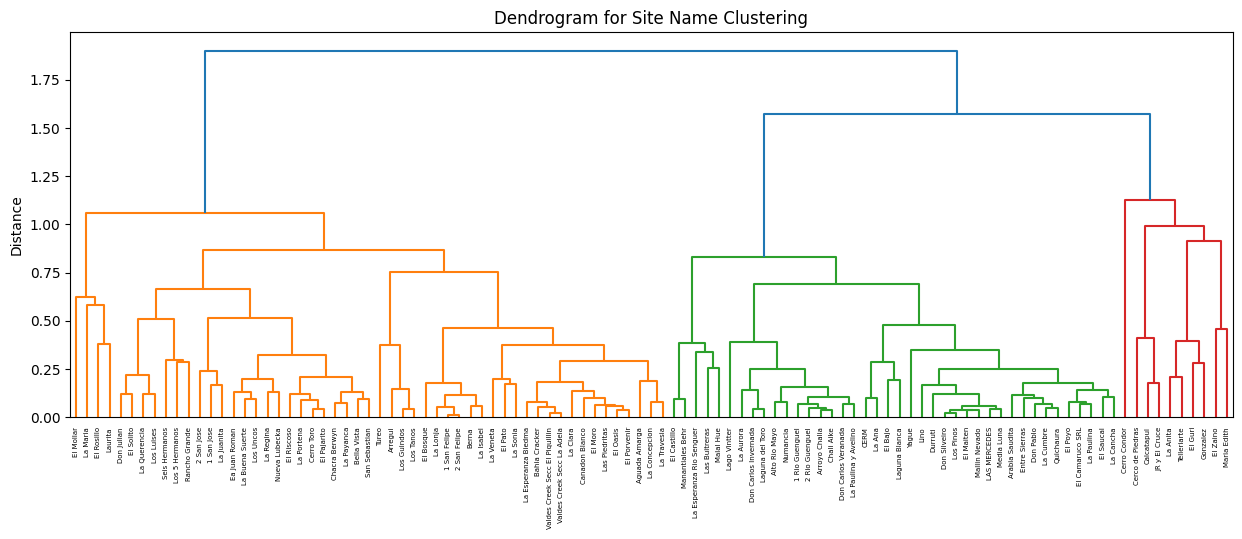

In [ ]:
# Generate the linkage matrix using the correlation matrix

# Perform hierarchical clustering
linkage_matrix = sch.linkage(correlation_matrix, method='complete', metric = "correlation")

# Plot the dendrogram
plt.figure(figsize=(15, 5))
dendrogram = sch.dendrogram(linkage_matrix, labels=correlation_matrix.index)

# Add title and labels
plt.title('Dendrogram for Site Name Clustering')
plt.ylabel('Distance')

plt.show()


## 5.3) Visualize the clusters on a heatmap

**Note:** Here I tried with method "ward"

In [ ]:
col_categories = maras_chubut.set_index('Site_Name')['Biozone']

row_categories = col_categories

unique_categories = pd.concat([row_categories, col_categories]).unique()

# Create a color palette and map categories to colors


palette = sns.color_palette("Set2", len(unique_categories))

lut = dict(zip(unique_categories, palette))

# Create color labels for rows and columns based on the categories
row_colors = row_categories.map(lut)
col_colors = col_categories.map(lut)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


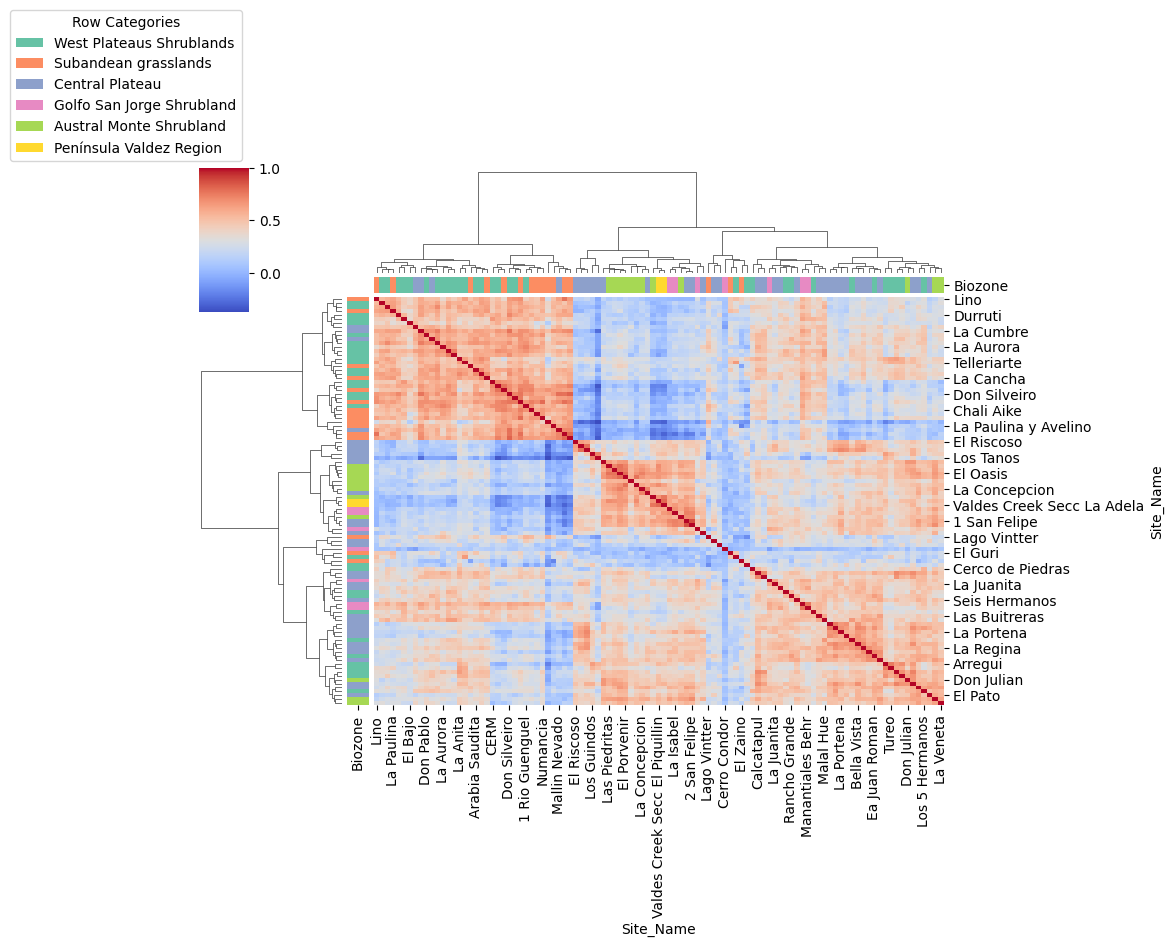

In [ ]:
from matplotlib.patches import Patch


# Create the clustermap
clustermap_site_names = sns.clustermap(correlation_matrix,
                                       cmap='coolwarm',
                                       method='ward',
                                       metric='euclidean',
                                       annot=False,
                                       fmt=".2f",
                                       figsize=(10, 8),
                                       row_colors=row_colors,  # Add row colors
                                       col_colors=col_colors)  # Add column colors


# Create custom legend for row colors
legend_elements = [Patch(facecolor=lut[category], label=category) for category in unique_categories]

# Add the legend to the plot
plt.legend(handles=legend_elements, title="Row Categories", bbox_to_anchor=(1, 1), loc='lower right')


# Show the plot
plt.show()


## 5.4)Make a data frame with clusters

In [ ]:
Z = linkage(pdist(correlation_matrix), method='ward', metric = 'euclidean')
cluster_labels = fcluster(Z, 4, criterion = 'maxclust') # looking at only 5 clusters

cluster_df = pd.DataFrame({
    'Site_Name': correlation_matrix.columns,
    'cluster': cluster_labels
})

print(cluster_df)

cluster_counts = cluster_df.groupby('cluster').size()

print(cluster_counts)

                          Site_Name  cluster
0                    1 Rio Guenguel        1
1                      1 San Felipe        2
2                        1 San Jose        2
3                    2 Rio Guenguel        1
4                      2 San Felipe        2
..                              ...      ...
98                      Telleriarte        1
99                            Tureo        4
100  Valdes Creek Secc El Piquillin        2
101      Valdes Creek Secc La Adela        2
102                           Yague        1

[103 rows x 2 columns]
cluster
1    36
2    24
3     8
4    35
dtype: int64


## 5.5) Map the 4 clusters

### a.) Get the coordinates from Chubut_samples.shp

**Note:** Taken from script 1. (specifically version 6 of it)

In [ ]:
path_points = r'Chubut_samples.shp'

# Shapefile is read into a GeoDf:
points = gpd.read_file(path_points)

# Select only the relevant columns for myscript ; geometry = coordinates
points = points[["Country", "Province", "Site_Name", "ID", "geometry"]]

points['Site_Name'] = points['Site_Name'].str.replace(r'[^\w\s]', '', regex=True)  # Remove all special characters


# Remove duplicated rows ; duplicates identified considering "Site_Name, "Country" and "Province"
points = points \
.drop_duplicates(subset=["Site_Name", "Country", "Province"], keep="first") \
.reset_index(drop = True)

# Get the site_list:
site_list = (points['Site_Name']) # extracts site names from Chubut sample points

# Change special characters:
site_list = site_list.str.replace('[()°]', '', regex=True) # removes specifically ()°
site_list = [unidecode(string) for string in site_list]
site_list = pd.Series(site_list) # converts back to pd.Series object, because the original site_list is a pd.Series object

# Add these modified sites back to the "points" GeoDf:
points["Site_Name"] = site_list

# Save as .csv to check it:
points_save = points.copy() # important to use .copy() ; otherwise, instead of making a new point file, the original "points" would be changed whenever "points_save" is changed
points_save['geometry'] = points_save['geometry'].apply(lambda x: x.wkt) # convert geometry into wkt, which csv can handle
points_save.to_csv('Chubut_samples_points_processed.csv', index=False)

# For testing, limit the size of the dataset
# points = points[0:5]
# site_list = site_list[0:5]

# test to check that this time site_list and GeodDf are identical:
# print(points.head)
# print(site_list.head)

<ipython-input-184-5666bb759b17>:30: UserWarning: Geometry column does not contain geometry.
  points_save['geometry'] = points_save['geometry'].apply(lambda x: x.wkt) # convert geometry into wkt, which csv can handle


### b.) Merge Geodf (from 5.5.1) and print it as a .csv

In [ ]:
# Save the cluster_df as a CSV file
cluster_df.to_csv('cluster_df.csv', index=False)

# Merging the points with cluster_df
merged_gdf = points.merge(cluster_df, on='Site_Name')

# Print the merged dataframe
print(merged_gdf)

       Country Province      Site_Name       ID                     geometry  \
0    Argentina   Chubut           CERM  #CH-001  POINT (-70.30031 -45.44061)   
1    Argentina   Chubut         La Ana  #CH-002  POINT (-70.26778 -45.42675)   
2    Argentina   Chubut     Media Luna  #CH-003  POINT (-71.39069 -45.58531)   
3    Argentina   Chubut  Alto Rio Mayo  #CH-004  POINT (-71.31325 -45.56728)   
4    Argentina   Chubut   1 San Felipe  #CH-005  POINT (-66.01511 -44.20461)   
..         ...      ...            ...      ...                          ...   
98   Argentina   Chubut   LAS MERCEDES  #CH-144  POINT (-70.92572 -44.69858)   
99   Argentina   Chubut  Nueva Lubecka  #CH-145    POINT (-70.344 -44.53789)   
100  Argentina   Chubut        El Poyo  #CH-146  POINT (-70.74372 -43.39158)   
101  Argentina   Chubut      El Saucal  #CH-147  POINT (-70.32483 -42.80264)   
102  Argentina   Chubut           Lino  #CH-148  POINT (-71.00556 -42.03336)   

     cluster  
0          1  
1        

### c.) Plot merged_gdf

In [ ]:
path_admin = r'Chubut_Mainland.shp'
admin = gpd.read_file(path_admin)

#g = json.loads(admin.to_json())
#coords = np.array(g['features'][0]['geometry']['coordinates'])
#roi = ee.Geometry.Polygon(coords.tolist())

print(admin)
#type(admin)

     GID_1 GID_0    COUNTRY  NAME_1 VARNAME_1 NL_NAME_1     TYPE_1 ENGTYPE_1  \
0  ARG.4_1   ARG  Argentina  Chubut        NA        NA  Provincia  Province   

  CC_1 HASC_1 ISO_1  ORIG_FID  Shape_Leng  Shape_Area  \
0   NA  AR.CH  AR-U         1   42.690672   25.089334   

                                            geometry  
0  POLYGON ((-68.61304 -46.00616, -68.63901 -46.0...  


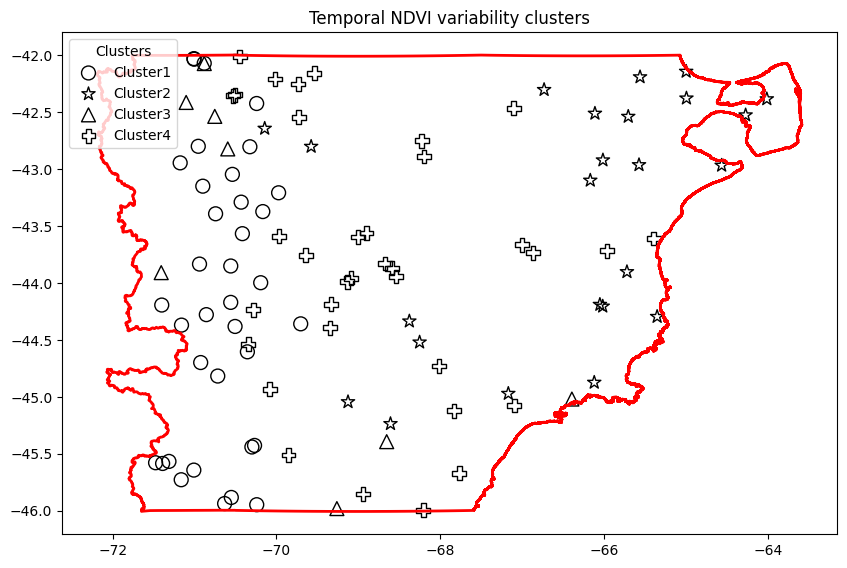

In [ ]:
# Assigning each cluster to a symbol
marker_dict = {
    1: 'o',  # Circle
    2: '*',  # Star
    3: '^',  # Triangle up
    4: 'P',  # Plus filled
}

fig, ax = plt.subplots(figsize=(10,8))

for cluster, marker in marker_dict.items():
  subset = merged_gdf[merged_gdf['cluster'] == cluster]
  subset.plot(ax=ax, marker=marker, color = 'none', edgecolor = 'k', markersize=100, label = f'Cluster{cluster}')

admin.plot(ax=ax, color ='none', edgecolor = 'red', linewidth =2)

plt.legend(title='Clusters')
plt.title('Temporal NDVI variability clusters')
plt.show()

### d.) 5.5.4 Overview count of clusters

In [ ]:
cluster_counts = merged_gdf.groupby('cluster').size()
print(cluster_counts)

cluster
1    36
2    24
3     8
4    35
dtype: int64


# 6.) Merge the clusters with the additional info on the site names (to be continued...)

## b.) Merge maras_chubut with merged_gdf

In [ ]:
merged_gdf_v2 = pd.merge(maras_chubut, merged_gdf, on=['Site_Name'], how='inner')

# Display the merged DataFrame
print(merged_gdf_v2)

# See all the column names in your dataframe
print(merged_gdf_v2.columns)

     Site_Name                   Biozone  Altitude VegCov    Country Province  \
0         CERM  West Plateaus Shrublands       543     48  Argentina   Chubut   
1         CERM  West Plateaus Shrublands       543   57,6  Argentina   Chubut   
2         CERM  West Plateaus Shrublands       543   39,6  Argentina   Chubut   
3       La Ana  West Plateaus Shrublands       535     49  Argentina   Chubut   
4       La Ana  West Plateaus Shrublands       535   44,8  Argentina   Chubut   
..         ...                       ...       ...    ...        ...      ...   
253  El Saucal  West Plateaus Shrublands       975   17,8  Argentina   Chubut   
254  El Saucal  West Plateaus Shrublands       975   22,6  Argentina   Chubut   
255       Lino      Subandean grasslands      1069   32,8  Argentina   Chubut   
256       Lino      Subandean grasslands      1069   27,2  Argentina   Chubut   
257       Lino      Subandean grasslands      1069     34  Argentina   Chubut   

          ID               

##c.) Clusters and altitude

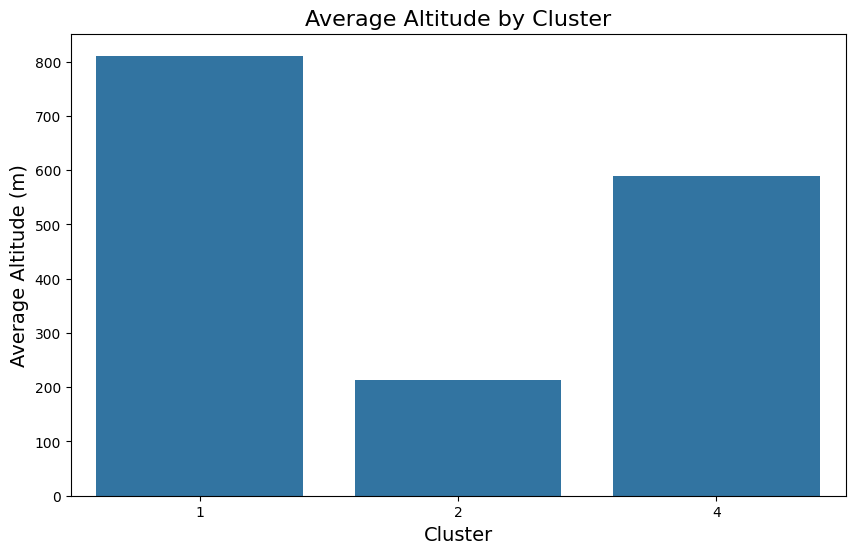

In [ ]:
# First, filter out cluster 3
filtered_data = merged_gdf_v2[merged_gdf_v2['cluster'] != 3]

# Group the data by 'cluster' and calculate the median altitude for each cluster (excluding cluster 3)
cluster_altitude = filtered_data.groupby('cluster')['Altitude'].median().reset_index()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='Altitude', data=cluster_altitude)

# Set the title and labels
plt.title('Average Altitude by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Altitude (m)', fontsize=14)

# Show the plot
plt.show()


## d.) Clusters and biozones

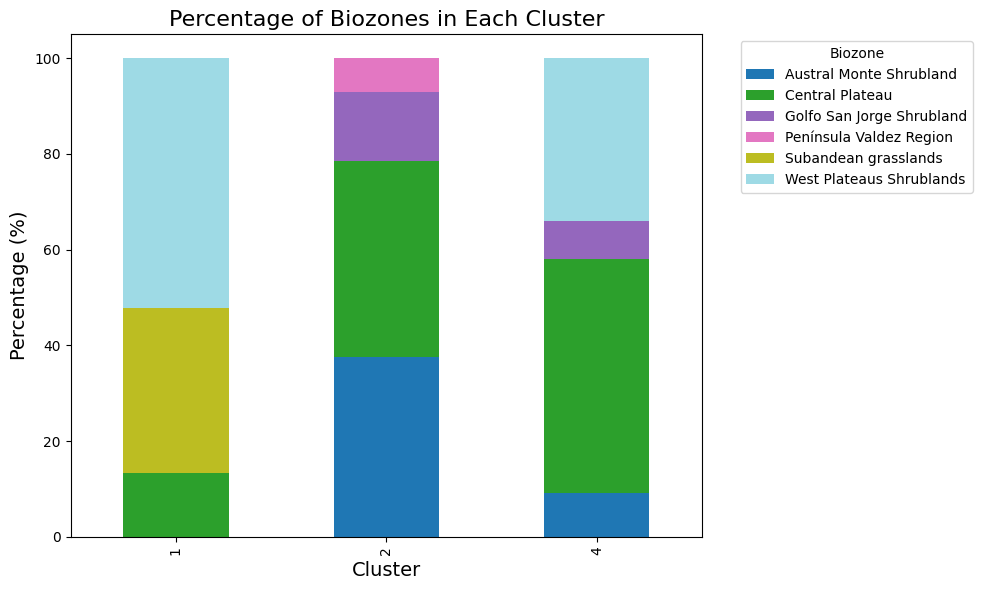

In [ ]:
# Step 1: Filter out cluster 3
filtered_data = merged_gdf_v2[merged_gdf_v2['cluster'] != 3]

# Step 2: Group by 'cluster' and 'Biozone', count the occurrences (excluding cluster 3)
biozone_cluster = filtered_data.groupby(['cluster', 'Biozone']).size().unstack(fill_value=0)

# Step 3: Convert counts to percentages
biozone_cluster_percentage = biozone_cluster.div(biozone_cluster.sum(axis=1), axis=0) * 100

# Step 4: Plot a stacked bar plot
biozone_cluster_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# Step 5: Customize the plot
plt.title('Percentage of Biozones in Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='Biozone', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

## e.) Clusters and Vegetation cover

First convert the column to proper numeric values.

In [ ]:
# Step 1: Replace commas with periods
merged_gdf_v2['VegCov'] = merged_gdf_v2['VegCov'].str.replace(',', '.')

# Step 2: Convert the column to float
merged_gdf_v2['VegCov'] = merged_gdf_v2['VegCov'].astype(float)


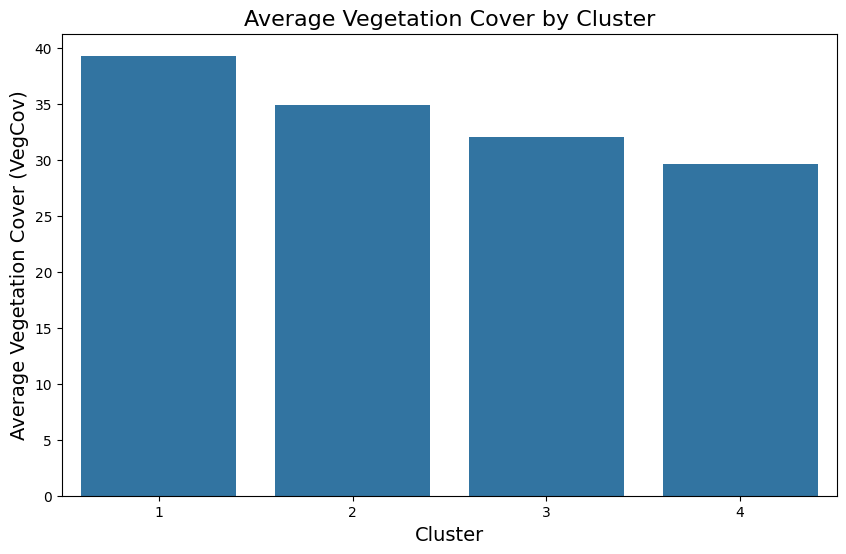

In [ ]:
# First, group the data by 'cluster' and calculate the mean 'VegCov' for each cluster
cluster_vegcov = merged_gdf_v2.groupby('cluster')['VegCov'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='VegCov', data=cluster_vegcov)

# Set the title and labels
plt.title('Average Vegetation Cover by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Vegetation Cover (VegCov)', fontsize=14)

# Show the plot
plt.show()